## **Import modules, prepare data extraction**

In [ ]:
!pip install pyunpack
!pip install patool

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import Holt
from pyunpack import Archive

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Archive('/content/drive/My Drive/BA/data_per_stores.zip').extractall('/content/drive/My Drive/BA/Data')

In [ ]:
# let's display one of the dataframes to see how it looks like and write the preprocessing function 
df = pd.read_csv('/content/drive/My Drive/BA/Data/data_CA_1.csv')
df.head(3)

,Unnamed: 0,id,store_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,sell_price
0,0,HOBBIES_1_001_CA_1,CA_1,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0_0_0,NaN
1,1,HOBBIES_1_002_CA_1,CA_1,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0_0_0,NaN
2,2,HOBBIES_1_003_CA_1,CA_1,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0_0_0,NaN


## **1. Get the cleaned data and preprocess it**

For this Holt's smoothing model, we only use the previous values of a time series to predict the next ones. This is a simple/baseline model that is not able to capture complex dependencies or effects such as seasonality, or to take the day into consideration to make a prediction. 

This model is an improvement of classic exponential smoothing models : instead of drawing a constant line, we draw a straight line. Some parameters can be tuned to get an optimal smoothing and an optimal slope.

### **1.1 Import the data and compute the aggregated demand (per day) for each store**

In [ ]:
def get_aggregated_demand(df_name):
    df=pd.read_csv(df_name)
    df2=df.groupby(['d']).sum().reset_index().set_index('d')['Demand']
    train = df2.iloc[:-28]
    valid=df2.iloc[-28:]
    return train, valid

In [ ]:
# compute the aggregated demand for each store in texas

train_tx_1,val_tx_1 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_TX_1.csv')
train_tx_2,val_tx_2 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_TX_2.csv')
train_tx_3,val_tx_3 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_TX_3.csv')


In [ ]:
# compute the aggregated demand for each store in wisconsin

train_wi_1,val_wi_1 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_WI_1.csv')
train_wi_2,val_wi_2 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_WI_2.csv')
train_wi_3,val_wi_3 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_WI_3.csv')


In [ ]:
# compute the aggregated demand for each store in california

train_ca_1,val_ca_1 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_CA_1.csv')
train_ca_2,val_ca_2 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_CA_2.csv')
train_ca_3,val_ca_3 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_CA_3.csv')
train_ca_4,val_ca_4 = get_aggregated_demand('/content/drive/My Drive/BA/Data/data_CA_4.csv')


In [ ]:
# gather results in one dataframe
train_df = pd.concat((train_tx_1, train_tx_2, train_tx_3, train_wi_1, train_wi_2, train_wi_3, train_ca_1, train_ca_2, train_ca_3, train_ca_4),axis = 1)
train_df.columns = ['TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4']
train_df.head()

,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,CA_1,CA_2,CA_3,CA_4
d,,,,,,,,,,
d_1,2556,3852,3030,2704,2256,4038,4337,3494,4739,1625
d_10,2174,2932,2213,1355,1836,3240,3157,2218,4912,1535
d_100,2412,2798,2230,1210,1276,2531,3033,2656,4217,1325
d_1000,2439,3252,2620,2574,3066,2243,3072,2513,5348,2133
d_1001,2510,3954,2680,3155,3821,2800,3955,3078,5745,2179


In [ ]:
# gather validation results in one dataframe
val_df = pd.concat((val_tx_1, val_tx_2, val_tx_3, val_wi_1, val_wi_2, val_wi_3, val_ca_1, val_ca_2, val_ca_3, val_ca_4),axis = 1)
val_df.columns = ['TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4']
val_df.head()

,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,CA_1,CA_2,CA_3,CA_4
d,,,,,,,,,,
d_974,3527,5504,3878,3582,4621,3508,5665,4562,6919,2675
d_975,3908,5180,3652,3421,4016,3431,6194,4176,7293,3125
d_976,2532,3536,3006,2361,3316,2757,4217,2650,5955,2563
d_977,3126,4406,3674,2727,3954,3126,4454,2779,6153,2331
d_978,2542,3538,2983,2362,4480,3535,3516,2861,5966,2117


In [ ]:
print('train dataset shape :',train_df.shape)
print('validation dataset shape : ',val_df.shape)

train dataset shape : (1885, 10)
validation dataset shape :  (28, 10)


### **1.2 Get an idea of what the data looks like**

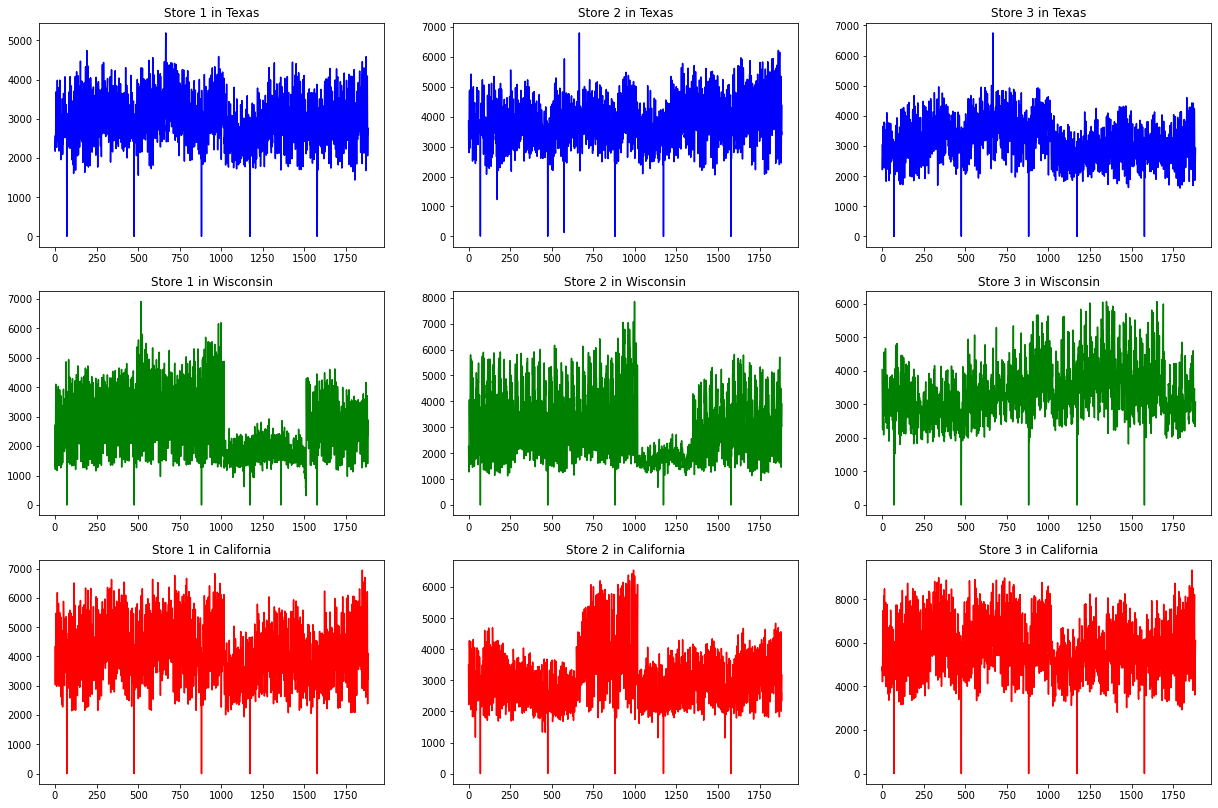

In [ ]:
days = np.arange(1885)
fig  = plt.figure(figsize = (21,14))
plt.subplot(3,3,1)
plt.plot(days, train_df['TX_1'].values, 'b')
plt.title('Store 1 in Texas')
plt.subplot(3,3,2)
plt.plot(days, train_df['TX_2'].values, 'b')
plt.title('Store 2 in Texas')
plt.subplot(3,3,3)
plt.plot(days, train_df['TX_3'].values, 'b')
plt.title('Store 3 in Texas')
plt.subplot(3,3,4)
plt.plot(days, train_df['WI_1'].values, 'g')
plt.title('Store 1 in Wisconsin')
plt.subplot(3,3,5)
plt.plot(days, train_df['WI_2'].values, 'g')
plt.title('Store 2 in Wisconsin')
plt.subplot(3,3,6)
plt.plot(days, train_df['WI_3'].values, 'g')
plt.title('Store 3 in Wisconsin')
plt.subplot(3,3,7)
plt.plot(days, train_df['CA_1'].values, 'r')
plt.title('Store 1 in California')
plt.subplot(3,3,8)
plt.plot(days, train_df['CA_2'].values, 'r')
plt.title('Store 2 in California')
plt.subplot(3,3,9)
plt.plot(days, train_df['CA_3'].values, 'r')
plt.title('Store 3 in California')
plt.show()

#### **Comments**

The variation seems to be different accross the states. Thus, we will tune hyperparameters for each state separately.

### **1.3 Helper functions**

In [ ]:
def rmsse(y_train,y_test,y_pred):
    y_train1 = y_train.shift()
    n = len(y_train)
    h = len(y_test)
    dividor = sum((y_train[1:]-y_train1[1:])**2)/(n-1)
    divident = sum((y_test-y_pred)**2)/h
    
    return divident/dividor

## **2. Build an exponential smoothing model**

In this part, we will train a Holt model from statsmodels (`statsmodels.tsa.holtwinters`) on the data related to the 1st store from Texas to see how it works. <br>
The hyperparameters tuning and work on other stores will be done in the next part of the notebook.

This model has 2 hyperparameters to tune : 
* the **smoothing level**, alpha
* the **smoothing slope**, beta

We will visualize the approximation for different sets of hyperparameters : 
* (alpha_1, beta_1) = (0.5, 0)
* (alpha_2, beta_2) = (0, 0.2)
* (alpha_3, beta_3) = (0.6, 0.05)
* (alpha_4, beta_4) = (0.3, 0.02)






In [ ]:
# see how it works 
model = Holt(train_df['TX_1'])

# parameters alpha = 0.5, beta = 0
fit1 = model.fit(smoothing_level = 0.8, smoothing_slope = 0)
pred1 = fit1.forecast(28)

# parameters alpha = 0, beta = 0.2
fit2 = model.fit(smoothing_level = 0.1, smoothing_slope = 0.1)
pred2 = fit2.forecast(28)

# parameters alpha = 0.6, beta = 0.05
fit3 = model.fit(smoothing_level = 0.6, smoothing_slope = 0.1)
pred3 = fit3.forecast(28)

# parameters alpha = 0.3, beta = 0.02
fit4 = model.fit(smoothing_level = 0.3, smoothing_slope = 0.02)
pred4 = fit4.forecast(28)

In [ ]:
rmsse_1 = rmsse(train_df['TX_1'], val_df['TX_1'].values, pred1)
rmsse_2 = rmsse(train_df['TX_1'], val_df['TX_1'].values, pred2)
rmsse_3 = rmsse(train_df['TX_1'], val_df['TX_1'].values, pred3)
rmsse_4 = rmsse(train_df['TX_1'], val_df['TX_1'].values, pred4)

print('Rmsse_1 : ', rmsse_1)
print('Rmsse_2 : ', rmsse_2)
print('Rmsse_3 : ', rmsse_3)
print('Rmsse_4 : ', rmsse_4)

Rmsse_1 :  0.9482072524923146
Rmsse_2 :  1.3078163537852894
Rmsse_3 :  2.177182678685522
Rmsse_4 :  1.1253407605400434


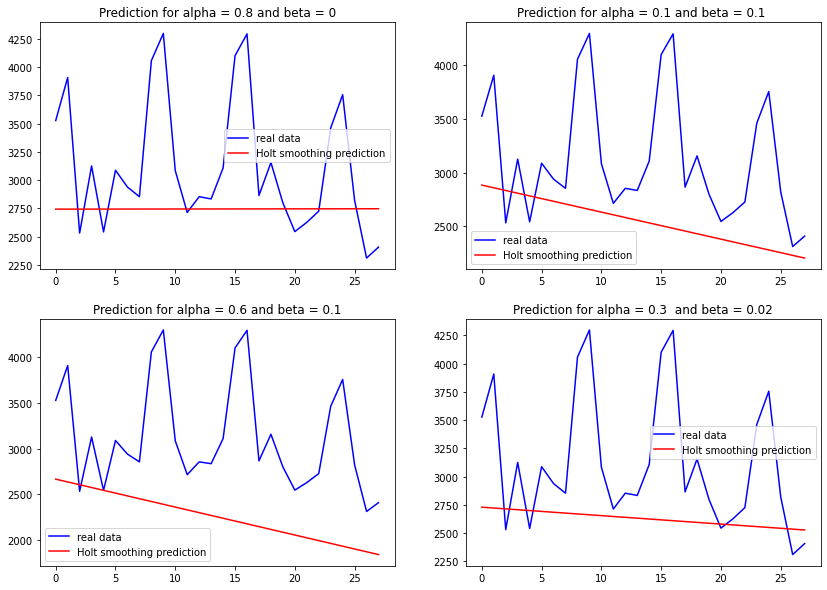

In [ ]:
days_ = np.arange(28)
fig  = plt.figure(figsize = (14,10))

plt.subplot(2,2,1)
plt.plot(days_, val_df['TX_1'].values, 'b', label = 'real data')
plt.plot(days_, pred1, 'r', label = 'Holt smoothing prediction')
plt.title('Prediction for alpha = 0.8 and beta = 0')
plt.legend(loc = 'best')

plt.subplot(2,2,2)
plt.plot(days_, val_df['TX_1'].values, 'b', label = 'real data')
plt.plot(days_, pred2, 'r', label = 'Holt smoothing prediction')
plt.title('Prediction for alpha = 0.1 and beta = 0.1 ')
plt.legend(loc = 'best')


plt.subplot(2,2,3)
plt.plot(days_, val_df['TX_1'].values, 'b', label = 'real data')
plt.plot(days_, pred3, 'r', label = 'Holt smoothing prediction')
plt.title('Prediction for alpha = 0.6 and beta = 0.1')
plt.legend(loc = 'best')


plt.subplot(2,2,4)
plt.plot(days_, val_df['TX_1'].values, 'b', label = 'real data')
plt.plot(days_, pred4, 'r', label = 'Holt smoothing prediction')
plt.title('Prediction for alpha = 0.3  and beta = 0.02')
plt.legend(loc = 'best')
plt.show()


#### **Comments** 
We notice that : 
* the slope coefficient has a direct effect on the slope of the curve : when it equlas 0, we are in the case of a classic exponential smoothing (no slope, constant approximation)
* the smoothing parameter alpha decides how much do we keep from the previous prediction; for a bigger alpha, the red line starts with a higher value since (the first value of this time series is higher than what happens next)

## **3. Parameter estimation for each of the states**

For each of the states, we will perform a grid search by evaluating the RMSSE for : 
* each store within a state 
* every tuple (alpha, beta) from the lists alphas and betas

Then, by averaging the RMSSEs from each store, we will select the couple of values that lead to the smallest error. 

We will use 20 values for each, which corresponds to 400 fits per store. Since the model is relatively simple and the computation time low, we can afford this.

### **3.1 Prepare the functions that will perform the grid search**

In [ ]:
alphas = np.linspace(0,1,20)
betas = np.linspace(0,0.2,20)
print(len(alphas), len(betas))

20 20


In [ ]:
# this function computes the prediction and the rmsse for each couple of values (alpha, beta)

In [ ]:
def predict_holt(alphas, betas, x,y) : 
  preds = []
  rmsses = np.zeros((20,20))
  for i in range(len(alphas)) : 
    for j in range(len(betas)) : 
      model = Holt(x)
      fit = model.fit(smoothing_level = alphas[i], smoothing_slope= betas[j])
      pred = fit.forecast(28)
      preds.append(pred)
      rmsse_ = rmsse(x, y.values, pred)
      rmsses[i,j] = rmsse_

  return rmsses, preds


In [ ]:
# for any reason, computing the three stores at the same time within one function leads colab to disconnect (No more RAM available) ; consequently, we do it step by step

### **3.2 Focus on Texas**

In [ ]:
rmsse_tx_1, preds_tx_1 = predict_holt(alphas, betas, train_df['TX_1'], val_df['TX_1'])

In [ ]:
rmsse_tx_2, preds_tx_2 = predict_holt(alphas, betas, train_df['TX_2'], val_df['TX_2'])

In [ ]:
rmsse_tx_3, preds_tx_3 = predict_holt(alphas, betas, train_df['TX_3'], val_df['TX_3'])

In [ ]:
# we average the rmsses to optimize hyperparameters
rmsse_tx = (rmsse_tx_1 + rmsse_tx_2 + rmsse_tx_3)/3
print('shape of the rmsse matrix : ',rmsse_tx.shape)
i,j = np.argmin(rmsse_tx)//20, np.argmin(rmsse_tx)%20
print('index of the optimal value for alpha : ', i)
print('index of the optimal value for alpha : ', j)

shape of the rmsse matrix :  (20, 20)
index of the optimal value for alpha :  1
index of the optimal value for alpha :  2


In [ ]:
alpha_tx, beta_tx = alphas[i], betas[j]
rmsse_tx_ = rmsse_tx[i,j]
print('optimal value for alpha in texas: ', alpha_tx )
print('optimal value for beta in texas: ', beta_tx )
print('associated rmsse', rmsse_tx_)

optimal value for alpha in texas:  0.05263157894736842
optimal value for beta in texas:  0.021052631578947368
associated rmsse 0.7101268470667444


### **3.3 Focus on Wisconsin**

In [ ]:
rmsse_wi_1, preds_wi_1 = predict_holt(alphas, betas, train_df['WI_1'], val_df['WI_1'])

In [ ]:
rmsse_wi_2, preds_wi_2 = predict_holt(alphas, betas, train_df['WI_2'], val_df['WI_2'])

In [ ]:
rmsse_wi_3, preds_wi_3 = predict_holt(alphas, betas, train_df['WI_3'], val_df['WI_3'])

In [ ]:
# we average the rmsses to optimize hyperparameters in Wisconsin 
rmsse_wi = (rmsse_wi_1 + rmsse_wi_2 + rmsse_wi_3)/3
print('shape of the rmsse matrix : ',rmsse_wi.shape)
i,j = np.argmin(rmsse_wi)//20, np.argmin(rmsse_wi)%20
print('index of the optimal value for alpha : ', i)
print('index of the optimal value for alpha : ', j)

shape of the rmsse matrix :  (20, 20)
index of the optimal value for alpha :  1
index of the optimal value for alpha :  3


In [ ]:
alpha_wi, beta_wi = alphas[i], betas[j]
rmsse_wi_ = rmsse_wi[i,j]
print('optimal value for alpha in Wisconsin: ', alpha_wi)
print('optimal value for beta in Wisconsin: ', beta_wi)
print('associated rmsse', rmsse_wi_)

optimal value for alpha in Wisconsin:  0.05263157894736842
optimal value for beta in Wisconsin:  0.031578947368421054
associated rmsse 0.5314089131827863


### **3.4 Focus on California**

In [ ]:
rmsse_ca_1, preds_ca_1 = predict_holt(alphas, betas, train_df['CA_1'], val_df['CA_1'])

In [ ]:
rmsse_ca_2, preds_ca_2 = predict_holt(alphas, betas, train_df['CA_2'], val_df['CA_2'])

In [ ]:
rmsse_ca_3, preds_ca_3 = predict_holt(alphas, betas, train_df['CA_3'], val_df['CA_3'])

In [ ]:
rmsse_ca_4, preds_ca_4 = predict_holt(alphas, betas, train_df['CA_4'], val_df['CA_4'])

In [ ]:
# we average the rmsses to optimize hyperparameters in Wisconsin 
rmsse_ca = (rmsse_ca_1 + rmsse_ca_2 + rmsse_ca_3 + rmsse_ca_4)/4
print('shape of the rmsse matrix : ',rmsse_ca.shape)
i,j = np.argmin(rmsse_ca)//20, np.argmin(rmsse_ca)%20
print('index of the optimal value for alpha : ', i)
print('index of the optimal value for alpha : ', j)

shape of the rmsse matrix :  (20, 20)
index of the optimal value for alpha :  1
index of the optimal value for alpha :  3


In [ ]:
alpha_ca, beta_ca = alphas[i], betas[j]
rmsse_ca_ = rmsse_ca[i,j]
print('optimal value for alpha in Wisconsin: ', alpha_ca)
print('optimal value for beta in Wisconsin: ', beta_ca)
print('associated rmsse', rmsse_ca_)

optimal value for alpha in Wisconsin:  0.05263157894736842
optimal value for beta in Wisconsin:  0.031578947368421054
associated rmsse 0.6779831591121114


### **3.5 Aggregate the results and conclude on the best model**

#### Observations and remarks : 

* we notice that even if the different time series looked different, and even if we could suppose that the sales in Texas, Wisconsin and California would be different from a business point of view (different ways of living, climates, customs...), **the hyperparameters that suit best our data are the same** or almost the same.

* this may be due to the fact that **our simple model cannot capture complex dependencies** such as seasonalities.

* we also notice that the value for the **slope coefficient is very small** : this is almost like basic exponential smoothing, where we draw a straight line. We can say that it makes sense since the slope could be helpful to model increasing or decreasing time series : however, for a time window of a month, we can expect that **similar levels at the beginning and the end of time series**, which explains why we get better results with a straight line.



In [ ]:
tx_params = [alpha_tx, beta_tx, rmsse_tx_]
wi_params = [alpha_wi, beta_wi, rmsse_wi_]
ca_params = [alpha_ca, beta_ca, rmsse_ca_]

grid_search_results = pd.DataFrame({'TX' : tx_params,'WI' : wi_params,'CA' : ca_params})
grid_search_results.index = ['alpha' ,'beta', 'rmsse']
grid_search_results

,TX,WI,CA
alpha,0.052632,0.052632,0.052632
beta,0.021053,0.031579,0.031579
rmsse,0.710127,0.531409,0.677983


#### **Decision on the parameters**

After seeing the results, we will choose to take the same parameters for the three states, which will be (rounded) :
* alpha = 0.053
* beta = 0.03

## **4. Evaluate the model on the different time series**

In [ ]:
# aggregate the train and validation demands in one array

train_data = []
val_data = []
for column in train_df.columns : 
  train_data.append(train_df[column].values)
  val_data.append(val_df[column].values)

train_data = np.array(train_data)
val_data = np.array(val_data)

print(train_data.shape, val_data.shape)

(10, 1885) (10, 28)


In [ ]:
rmmses = np.zeros(10)
preds = []
alpha = alpha_ca
beta = beta_ca
for i in range(train_data.shape[0]) :
    model = Holt(train_data[i])
    fit = model.fit(smoothing_level = alpha, smoothing_slope = beta)
    pred = fit.forecast(28)
    preds.append(pred)
    train_serie = pd.Series(train_data[i])
    rmsse_ = rmsse(train_serie, val_data[i], pred)
    rmmses[i] = rmsse_

In [ ]:
rmsse_results = pd.DataFrame({'RMSSE' : rmmses})
rmsse_results.index = ['TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4']
rmsse_results

,RMSSE
TX_1,0.662399
TX_2,0.811487
TX_3,0.659441
WI_1,0.335166
WI_2,0.763116
WI_3,0.495944
CA_1,0.763063
CA_2,0.712931
CA_3,0.674388
CA_4,0.561551


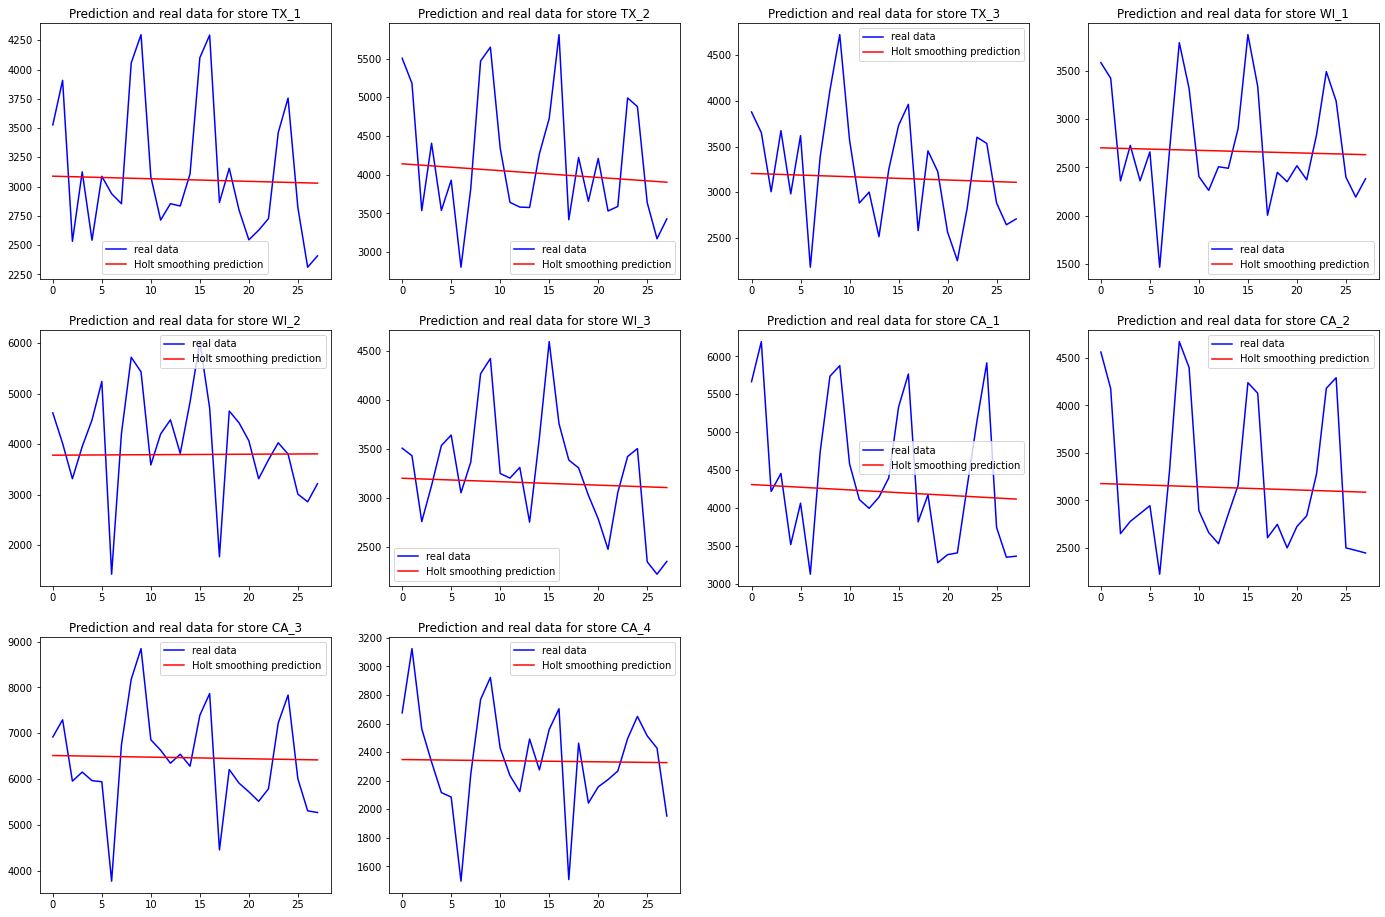

In [ ]:
stores = ['TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4']
days_ = np.arange(28)

plt.figure(figsize = (24,16))
for k in range(train_data.shape[0]) : 
  plt.subplot(3,4,k+1)
  plt.plot(days_, val_data[k], 'b', label = 'real data')
  plt.plot(days_, preds[k], 'r', label = 'Holt smoothing prediction')
  plt.title(f"Prediction and real data for store {stores[k]}")
  plt.legend(loc = 'best')